# Úkol č. 3 - shlukování

  * **Deadline je do 28. 12. 2022, 23:59:59**, pokud odevzdáte úkol do 4. 1. 2023, 23:59:59, budete penalizování -4 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s problematikou shlukování.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

  * Zdrojem dat je soubor `CC GENERAL.csv` (originál zde: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata).
  * Popis datasetu najdete v souboru `data_description.txt`.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **16 bodů**:
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Na jeho základě adekvátně reagujte na problematické věci v datech (chybějící hodnoty, atd.) a vysvětlete motivaci k provedeným krokům.
  * Vytvořte **vlastní implementaci** algoritmu KMeans.
  * Pomocí této vlastní implementace proveďte shlukování.
  * Zopakujte shlukování s implementací `sklearn.cluster.KMeans`. Pokuste se sladit hyperparametry tak, abyste dostali stejné výsledky. Pokud se Vám to nepovede, diskutujte proč.
  * Pokuste se odhadnout vhodný počet shluků (např. metodou lokte).
  * Proveďte také aglomerativní hierarchické shlukování (použijte existující implementaci) a nakreslete dendrogram (resp. alespoň jeho vhodnou horní část).
  * Zopakujte předchozí kroky a při tom experimentujte s různými hodnotami hyperparametrů a také se standardizací/normalizací dat.
    * Kvalitu vytvořených shluků můžete analyzovat pomocí metody Silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
  * Cílem je vybrat shlukování, které Vám přijde nejlepší (můžete přihlédnout k následujícímu bodu). Popište, proč jste ho vybrali.
  * Na tomto vybraném shlukování se pokuste interpretovat výsledné shluky.
    * Snažte se identifikovat a popsat typy uživatelů kreditních karet podle Vámi zvolených vybraných kritérií. Můžete přitom koukat například na BALANCE, PURCHASES, CASH_ADVANCE, PAYMENTS, atd.
  

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.
  * Opravující Vám ve výjimečných případech může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale stěžejní a má hlavní vliv na hodnocení.

In [1]:
### odtud už je to Vaše

# Řešení

* Naimportujeme knihovny

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import ParameterGrid

## Příprava dat

* Načteme data

In [3]:
data = pd.read_csv('CC GENERAL.csv')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


* Podiváme se na data aby zjístit počet NaN hodnot a datatypy sloupců.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

* Příznak ```CUST_ID``` smažeme, protože pro shlukování ho nepotřebujeme.

In [5]:
data = data.drop(columns=['CUST_ID'])

* Zjistíme počet **NaN** hodnot v jednotlivých sloupcích.

In [6]:
data.isnull().sum(axis=0)

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

* Nejvíc **NaN** hodnot obsahuje příznak ```MINIMUM_PAYMENTS```. Ten má 313 **NaN** hodnot. Taky jenom jednu **NaN** hodnotu obsahuje sloupec ```CREDIT_LIMIT```. Aby nezhoršit výsledné shlukování střední hodnotou, kterou jsme nahradíme **NaN** hodnoty, smažeme všechny řádky, které obsahují **NaN** hodnoty.

In [7]:
data = data.dropna()
data.isnull().sum(axis=0)

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

* Pro vlastní implementaci algoritmu ```KMeans``` resetujeme index v celém datasetu, a vznikly sloupec ```index``` smažeme.

In [8]:
data = data.reset_index()
data = data.drop(columns=['index'])
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
3,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
4,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


## Vlastní implementaci algoritmu KMeans

* Teď provedeme vlastní implementaci algoritmu ```KMeans```. Na to budeme potřebovat několik pomocných. funkci.

* Funkce ```get_start_centers``` vybere náhodně počáteční rozmístění **k** středových bodů, kde **k** je proměnná ```clust_count```. Pomoci aplikováni funkce ```sample()``` s podmínkou na počet shluků, vybereme **k** náhodných řádku z celého datasetu a vrátíme dataset, který obsahuje tyto řádky.

In [9]:
def get_start_centers(clust_count, data):
    centers = data.sample(n = clust_count)
    return centers

* Funkce ```search_cluster``` přiřadí každý bod(řádek) do nějakého shluku na základě vzdálenosti bodu od centru shluku. Bod bude patřit k tomu shluku, center kterého bude nejblíž. 
* Ze začátku musíme resetovat index v ```centers```, aby index centra(bude začínat od nuly) se dalo použit na indexování shluku a iterovaní v cyklu. Taky vytvoříme kopii celého datesetu, aby v ni zapisovat v sloupec ```cluster``` číslo shluku ke kterému tento bod patří. Vzdálenost od jednotlivých centrů budeme počítat pomoci normy rozdílu bodu od centru a to celý na druhou. Výsledek budeme zapisovat v slovník a pak číslo shluku s nejmenší normou přiřadíme bodu v ```fin_clast```. Funkce vrátí dataframe, kde každý záznam bude mít ve sloupci ```cluster``` číslo shluku.
* Na zjištění normy použijeme funkce ```norm``` z knihovny ```numpy```.

In [10]:
def search_cluster(centers, df):
    
    centers = centers.reset_index()
    centers = centers.drop(columns=['index'])

    fin_clast = df.copy(deep=False)

    for i in range(len(df)):
        min_index = {}
        for j in range(len(centers)):
            #for centers
            if(np.array_equal(df.loc[i,:], centers.loc[j,:])):
                min_index[0] = j
                break
            #other points
            else:
                val_norm = np.square(norm(df.loc[i,:] - centers.loc[j,:])) #compute distance
                min_index[val_norm] = j #get number of cluster
        
        fin_clast.loc[i,'cluster'] = min_index[min(min_index.keys())] #add in cluster
    
    return fin_clast
        

* Funkce ```calculate_centers``` počítá nové středy pro jednotlivé shluky a zapisuje je v prázdný dataframe ```centers```. Centr shluku se dá snadno zjistit pomoci funkce ```mean()```. Tu aplikujeme na všechny řádky, které jsou v určitém shluku. Funkce ve výsledku vrátí  dataframe ```centers```, který bude obsahovat centry shluků.

In [11]:
def calculate_centers(df, clusters_count):
    centers = pd.DataFrame(columns= df.columns)
    for i in range(0, clusters_count):
        tmp = df[df['cluster'] == i]
        tmp = tmp.drop(columns=['cluster'])
        centers.loc[len(centers.index)] = tmp.mean()
    
    return centers

* Funkce fit provede rozdělení cele množiny dat na shluky.
    1. ```clust_count``` - počet shluků
    2. ```data``` - celý dataset
    3. ```count_of_iters``` - počet iteraci
* Na začátku pomoci funkce ```get_start_centers```, vybereme centry budoucích shluku. Pak použitím cyklu budeme třídit body do shluku. Proměnnou ```old_cents``` použijeme pro jednu z ukončovacích podmínek. Pokud mezi iteracemi středy shluků se nemění, zastavíme iterovaní a dostaneme výsledné shluky. Pokud to nenastane po ```count_of_iters``` iteraci, iterovaní  se taky zastaví. Musíme taky při každé iteraci odstraňovat sloupec ```cluster``` aby neovlivňoval rozděleni do shluku. Postupně budeme volat funkci ```search_cluster```, která roztřídí body do shluku, a pak funkci ```calculate_centers```, která spočítá nové středy shluků. Na konci běhu funkce, vrátíme dataframe, ve kterém každý bod(řádek) bude mít ve sloupci ```cluster``` číslo svého shluku

In [12]:
def fit(clust_count, data, count_of_iters):
    cents = get_start_centers(clust_count, data)
    fin_clast = data
    for i in range(count_of_iters):
        old_cents = cents
        if 'cluster' in fin_clast.columns:
            fin_clast = fin_clast.drop(columns='cluster')
        
        fin_clast = search_cluster(cents, fin_clast)
        cents = calculate_centers(fin_clast, clust_count)
        cents = cents.drop(columns='cluster')
        if(np.array_equal(old_cents, cents)):
            break
    
    return fin_clast

* Zavoláme funkci ```fit``` na náš dataset, a zkusíme roztřídit ho na dva shluky. Počet iteraci zvolíme 300, jak to má defaultně implementace ze sklearn. Pomoci ```value_counts``` zjistíme počet bodu v jednotlivých shlucích.

In [13]:
fin_clast = fit(2, data, 300)
fin_clast['cluster'].value_counts()

0.0    6797
1.0    1839
Name: cluster, dtype: int64

* Změříme přesnost pomoci silhouette score. Aby ho použit, musíme převést sloupec ```cluster``` na numpy array pomoci funkce ```to_numpy()```.

In [14]:
km_labels = fin_clast['cluster'].to_numpy()
print('My KMeans Silhouette score: ' + str(silhouette_score(data, km_labels)))

My KMeans Silhouette score: 0.511307699456009


* Teď stejné kroky provedeme na implementaci ```KMeans``` ze sklearn a změříme přesnost pomoci silhouette score.

In [15]:
k = 2
kmeans = KMeans(n_clusters = k).fit(data)
unique, counts = np.unique(kmeans.labels_, return_counts=True)

dict(zip(unique, counts))

{0: 6797, 1: 1839}

In [16]:
print('Sklearn KMeans Silhouette score: ' + str(silhouette_score(data, kmeans.labels_)))

Sklearn KMeans Silhouette score: 0.511307699456009


* Z výsledku silhouette score a rozděleni bodu do jednotlivých shluku  můžeme snadno pochopit, že vlastní implementace dává stejné výsledky jak i implementace ze sklearn.

## Odhad počtu shluků

* Na odhalování počtu shluku, můžeme použit nebo metodu lokte nebo silhouette score. Zkusíme naměřit hodnoty funkci pro interval počtu shluků od 2 do 6 včetně. Pro metodu lokte budeme potřebovat hodnotu účelové funkce, kterou můžeme snadno zjistit pomoci atributu ```inertia_```. Počet shluků budeme zjišťovat na implementaci z sklearn, která je mnohem rychlejší než vlastní implementace.

In [17]:
func_val = {}
silh_score_val = {}

for k in range(1, 7):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data)
    func_val[k] = kmeans.inertia_

for k in range(2, 7):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data)
    silh_score_val[k] = silhouette_score(data, kmeans.labels_)


* Vytvoříme grafy pro metodu lokte a silhouette score.

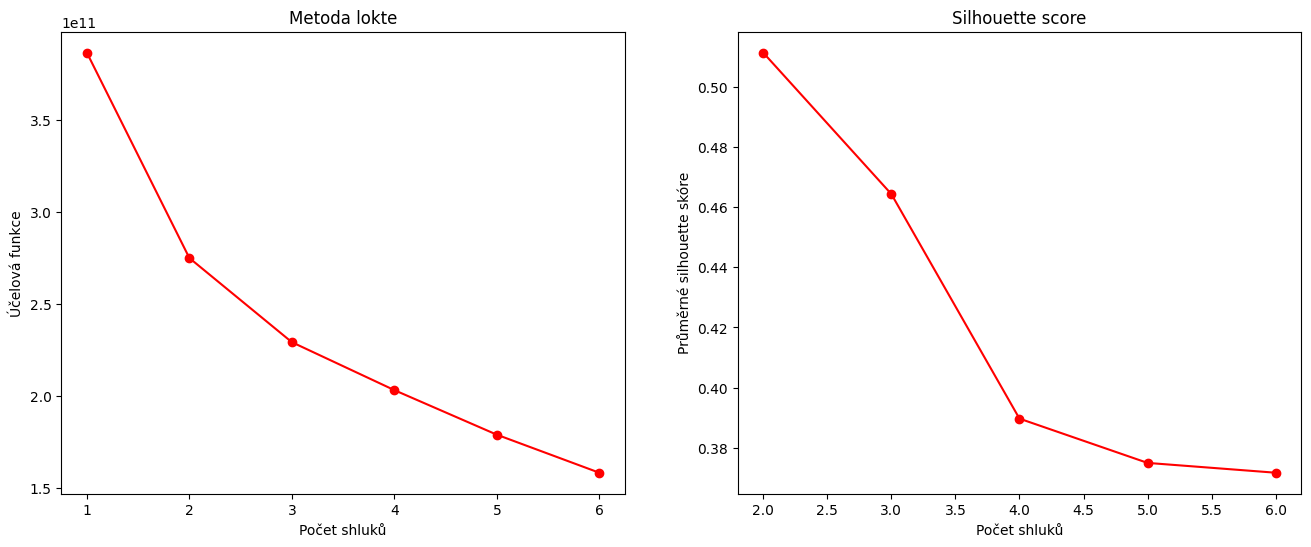

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6)) #create two parallel tabels

ax1.plot(func_val.keys(), func_val.values(), 'or-')
ax1.set_xlabel('Počet shluků')
ax1.set_ylabel('Účelová funkce')
ax1.set_title('Metoda lokte')

ax2.plot(silh_score_val.keys(), silh_score_val.values(), 'or-')
ax2.set_xlabel('Počet shluků')
ax2.set_ylabel('Průměrné silhouette skóre')
ax2.set_title('Silhouette score')
plt.show()

* V našem případě metoda lokte(hledáme místo zlomu funkce) je docela těžce použitelná, kvůli tvaru grafu. Z metody lokte, můžeme říct, že počet shluku bude nejspíš 2 nebo 3, ale ověříme to na silhouette score. Z silhouette score už jistě můžeme říct, že správnou volbou počtu shluků bude 2.


## Standardizace a MinMaxNormalizace

* Zkusíme teď provést nad daty standardizaci a normalizaci.

In [19]:
scaler_stand = StandardScaler()
Data_Standard = scaler_stand.fit_transform(data)
scaler_norm = MinMaxScaler()
Data_MinMaxNorm = scaler_norm.fit_transform(data)

* Naměříme hodnoty na stejném intervalu ale pro standardizovaná data.

In [20]:
silh_score_stand = {}
func_val_stand = {}

for k in range(1, 7):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(Data_Standard)
    func_val_stand[k] = kmeans.inertia_

for k in range(2, 7):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(Data_Standard)
    silh_score_stand[k] = silhouette_score(Data_Standard, kmeans.labels_)


* Vytvoříme grafy pro metodu lokte a silhouette score.

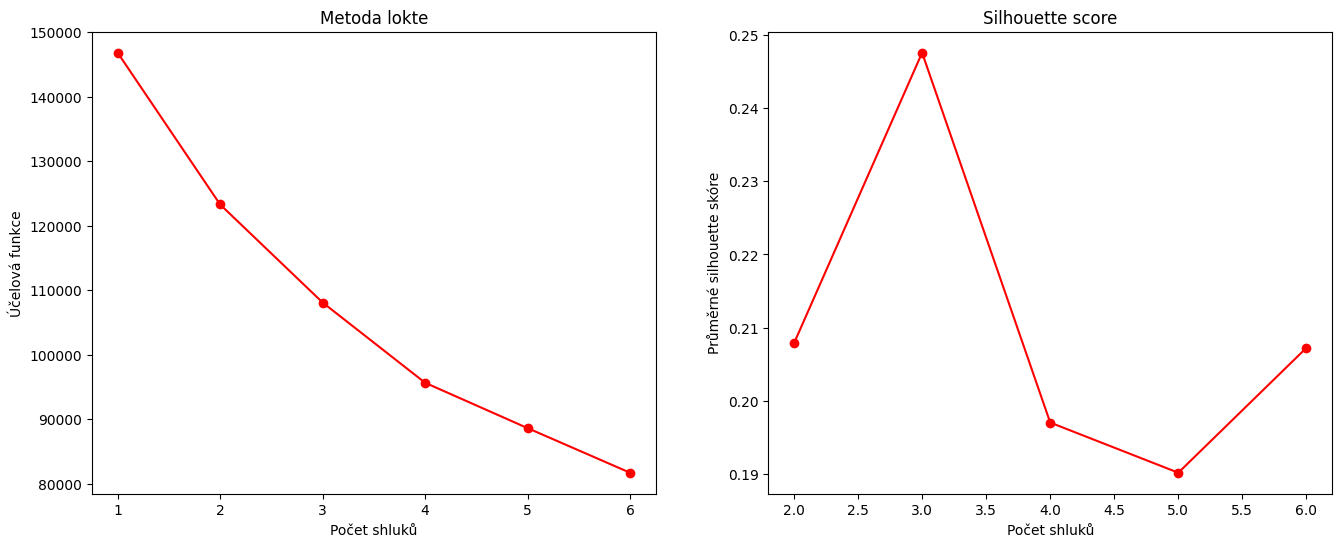

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6)) #create two parallel tabels

ax1.plot(func_val_stand.keys(), func_val_stand.values(), 'or-')
ax1.set_xlabel('Počet shluků')
ax1.set_ylabel('Účelová funkce')
ax1.set_title('Metoda lokte')

ax2.plot(silh_score_stand.keys(), silh_score_stand.values(), 'or-')
ax2.set_xlabel('Počet shluků')
ax2.set_ylabel('Průměrné silhouette skóre')
ax2.set_title('Silhouette score')
plt.show()

* Z grafů můžeme nahlédnout, že při standardizaci dat, nejlepší počet shluku podle silhouette score je 3. Taky můžeme říct, že na standardizovaných datech silhouette score je dvakrát horší(0,25 místo 0,50) než na původních datech. Z toho plyne, že standardizaci nebudeme potřebovat.

* Zopakujeme stejné kroky pro MinMaxNormalizaci.

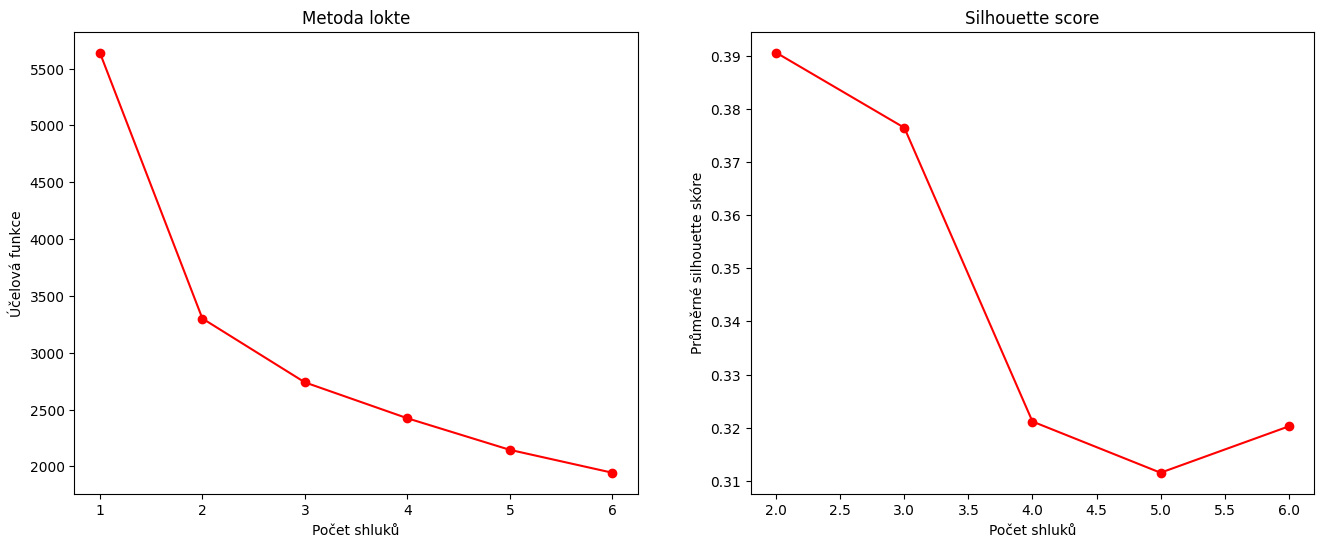

In [22]:
silh_score_norm = {}
func_val_norm = {}

for k in range(1, 7):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(Data_MinMaxNorm)
    func_val_norm[k] = kmeans.inertia_

for k in range(2, 7):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(Data_MinMaxNorm)
    silh_score_norm[k] = silhouette_score(Data_MinMaxNorm, kmeans.labels_)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6)) #create two parallel tabels

ax1.plot(func_val_norm.keys(), func_val_norm.values(), 'or-')
ax1.set_xlabel('Počet shluků')
ax1.set_ylabel('Účelová funkce')
ax1.set_title('Metoda lokte')

ax2.plot(silh_score_norm.keys(), silh_score_norm.values(), 'or-')
ax2.set_xlabel('Počet shluků')
ax2.set_ylabel('Průměrné silhouette skóre')
ax2.set_title('Silhouette score')
plt.show()

* V případě MinMaxNormalizaci situace je trochu lepší ale pořad hodnota silhouette score je horší než u původních dat. Vhodný počet shluků je taky 2. Pro MinMaxNormalizaci je taky docela použitelná metoda lokte, zlom funkce je dobře pozorovatelný ve dvojce.

## Ladění hyperparametrů

* Teď zkusíme odladit hyperparametry pro algoritm KMeans. Na ladění použijeme ParametrGrid, který je docela vhodný pro ladění vice hyperparametrů.
* Budeme ladit následující hyperparametry:
    1. **n_clusters** - počet shluků
    2. **max_iter** - počet iteraci
    3. **init** - algoritm výběru počátečního centru shluku

In [23]:
val_arr = []
hyperparam_arr = {
    'n_clusters': range(2, 6),
    'max_iter': range(100, 600, 100),
    'init': ['k-means++', 'random'],
}
param = ParameterGrid(hyperparam_arr)
for hyp in param:
    kmeans = KMeans(n_clusters = hyp['n_clusters'], max_iter = hyp['max_iter'], init = hyp['init'], random_state = 42).fit(data)
    val_arr.append(silhouette_score(data, kmeans.labels_))


* Zjistíme nejlepší hyperparametry(nejvyšší silhouette score).

In [24]:
best_params = param[np.argmax(val_arr)]
print('best params ', best_params)

best params  {'n_clusters': 2, 'max_iter': 100, 'init': 'k-means++'}


* Provedeme shlukování s požitím těchto hodnot hyperparametrů.

In [25]:
kmeans = KMeans(n_clusters = best_params['n_clusters'], max_iter = best_params['max_iter'], init = best_params['init'], random_state = 42).fit(data)
print('KMeans Silhouette score with tuning: ' + str(silhouette_score(data, kmeans.labels_)))

KMeans Silhouette score with tuning: 0.511307699456009


* Výsledný silhouette score pro KMeans bude 0.511. 
* Taky můžeme říct, že potřebujeme jenom 100 iteraci místo defaultních 300

## Aglomerativní hierarchické shlukování

* Teď zkusíme použit aglomerativní hierarchické shlukování a zobrazit dendrogram, aby zjistit vhodný počet shluků. Nastavíme distance_threshold  na nulu, ten řídí maximální vzdálenost pro spojení dvou bodu do shluku. Počet shluku v takovém případě musí být None(podle dokumentace)

In [26]:
aggl_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
aggl_clust = aggl_clust.fit(data)

* Aby vytvořit dendrogram, budeme potřebovat pomocnou funkci, která vytvoří matici propojení. Funkce ```plot_dendrogram``` je už implementována v [dokumentaci sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py). Změníme jenom návratovou hodnotu na matici propojení.

In [27]:
def plot_dendrogram(model):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix


* Nalezneme matici propojení a vytvoříme dendrogram. Použitím parametru ```truncate_mode```, který nastavíme na **lastp**, vykreslíme jenom posledních **p** spojeních shluků. Parametr **p** nastavíme na 25, aby graf byl čitelný. Otočím popisy x osy na 90 stupňů a nastavíme velikost fontu popisů na 12.

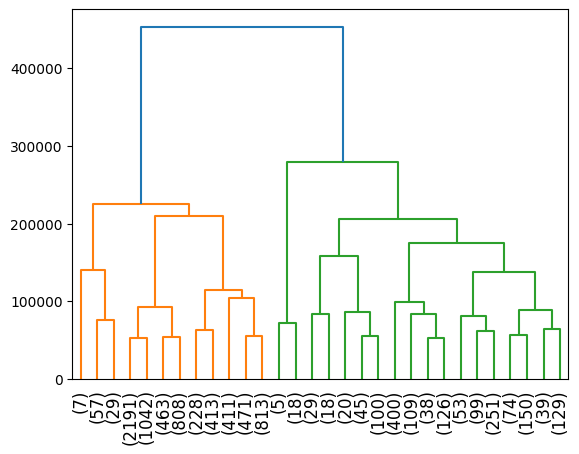

In [28]:
mat_link = plot_dendrogram(aggl_clust)
dendrogram(mat_link, truncate_mode="lastp", p=30, leaf_rotation=90, leaf_font_size=12)
plt.show()

* Z dendrogramu můžeme říct, že vhodný počet shluků bude nejspíš dva.(rozřízneme dendrogram mezi vzdálenosti 300000 až 400000).

* Zjistíme silhouette score pro 2 shluky. Pokusíme se taky standardizovat a normalizovat data, a změřit silhouette score na nich.

In [29]:
aggl_clust = AgglomerativeClustering(n_clusters=2)
aggl_clust = aggl_clust.fit(data)

aggl_clust_stand = AgglomerativeClustering(n_clusters=2)
aggl_clust_stand = aggl_clust_stand.fit(Data_Standard)

aggl_clust_norm = AgglomerativeClustering(n_clusters=2)
aggl_clust_norm = aggl_clust_norm.fit(Data_MinMaxNorm)
print('AgglomerativeClustering Silhouette score: ' + str(silhouette_score(data, aggl_clust.labels_)))
print('AgglomerativeClustering Silhouette score with standard: ' + str(silhouette_score(data, aggl_clust_stand.labels_)))
print('AgglomerativeClustering Silhouette score with MinMaxNorm: ' + str(silhouette_score(data, aggl_clust_norm.labels_)))


AgglomerativeClustering Silhouette score: 0.49972485265477606
AgglomerativeClustering Silhouette score with standard: 0.07045199425872849
AgglomerativeClustering Silhouette score with MinMaxNorm: 0.04332510677231934


* Podíváme se na výsledné shluky.

In [30]:
unique, counts = np.unique(aggl_clust.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 1703, 1: 6933}

* Silhouette score je docela slušný ale KMeans je stejně lepší. Pro standardizovaná a normalizovaná data, je výsledek mnohem horší.
* Pokusíme tedy ladit hyperparametry. Těch bude dva:
    1. **affinity** - metrika
    2. **linkage** - metoda měření vzdálenosti shluků

In [31]:
val_arr_agl = []
hyperparam_arr_agl = {
    'affinity': ['euclidean', 'manhattan', 'l1', 'l2'],
    'linkage': ['complete', 'average', 'single'],
}
param_agl = ParameterGrid(hyperparam_arr_agl)
for hyp in param_agl:
    aggl_clust = AgglomerativeClustering(n_clusters = 2, affinity = hyp['affinity'], linkage = hyp['linkage'], ).fit(data)
    val_arr_agl.append(silhouette_score(data, aggl_clust.labels_))


* Zjistíme nejlepší hyperparametry(nejvyšší silhouette score).

In [32]:
best_params_agl = param_agl[np.argmax(val_arr_agl)]
print('best params ', best_params_agl)

best params  {'linkage': 'average', 'affinity': 'euclidean'}


* Provedeme shlukování s požitím těchto hodnot hyperparametrů.

In [33]:
aggl_clust = AgglomerativeClustering(n_clusters = 2, affinity = best_params_agl['affinity'], linkage = best_params_agl['linkage']).fit(data)
print('AgglomerativeClustering Silhouette score: ' + str(silhouette_score(data, aggl_clust.labels_)))

AgglomerativeClustering Silhouette score: 0.9080877970556458


* Kupodivu po ladění hyperparametrů dostáváme pro aglomerativní hierarchické shlukování nejlepší výsledek, který je lepší než výsledek pro KMeans (0.51). Výsledek 0.9 v silhouette score znamená, že body jsou ve většině případu ve správném shluku.(Nejblíž bude centr shluku ve kterém jsou)
* Podíváme se teď na naše shluky.

In [34]:
unique, counts = np.unique(aggl_clust.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 8635, 1: 1}

* Z rozdělení bodu do shluku už to nevypadá tak dobře. Máme jeden velký shluk, který obsahuje skoro všechny body a jeden shluk který obsahuje jenom jeden bod. Z toho plyne že takové hyperparametry nebudou pro naši data dobrou volbou. Pokud budeme používat defaultní hyperparametry( ward a euclidean) bude výsledek lepší z pohledu rozděleni dat. Ward linkage bohužel v ladění hyperparametrů se nedá použit, protože funguje jenom s euklidovskou metrikou.

## Volba nejlepšího shlukování

* Nejlepší algoritm budeme volit pomoci silhouette score. Čím větší je silhouette score tím blíž bude bod k centru svého shluku. Pokud to aplikujeme na celou množinu bodu, výsledkem bude průměrná hodnota silhouette score pro celou množinu.

In [35]:
aggl_clust = AgglomerativeClustering(n_clusters = 2).fit(data)
print('AgglomerativeClustering Silhouette score: ' + str(silhouette_score(data, aggl_clust.labels_)))

fin_clast = fit(2, data, 100)
km_labels = fin_clast['cluster'].to_numpy()
print('My KMeans Silhouette score: ' + str(silhouette_score(data, km_labels)))

kmeans = KMeans(n_clusters = best_params['n_clusters'], max_iter = best_params['max_iter'], init = best_params['init'], random_state = 42).fit(data)
print('Sklearn KMeans Silhouette score: ' + str(silhouette_score(data, kmeans.labels_)))

AgglomerativeClustering Silhouette score: 0.49972485265477606
My KMeans Silhouette score: 0.5112950027519931
Sklearn KMeans Silhouette score: 0.511307699456009


* Z hodnot silhouette score můžeme říct, že lepší bude KMeans shlukování. Můžeme zvolit vlastní implementaci pro následující interpretaci výsledků.

## Interpretace výsledných shluků

* Z předchozího odstavce už víme, že KMeans shlukování je nejlepší proto budeme ho pro interpretaci výsledků používat.

In [36]:
fin_clast['cluster'].value_counts()

1.0    6798
0.0    1838
Name: cluster, dtype: int64

* Uvedeme taky počet v procentech, bude se to hodit u závěru.

In [76]:
fin_clast['cluster'].value_counts(normalize=True)


1.0    0.78717
0.0    0.21283
Name: cluster, dtype: float64

* Máme dva shluky, které se pokusíme analyzovat.
* Rozdělíme výsledný dataset podle sloupce cluster.

In [68]:
zero_cluster = fin_clast[fin_clast['cluster'] == 0.0]
first_cluster = fin_clast[fin_clast['cluster'] == 1.0]

* Zjistíme střední hodnoty příznaků v nultým a prvním shluku. Pomoci funkce ```round``` zaokrouhlíme to na dva desetinná místa.

In [69]:
display(first_cluster.mean().round(2))

BALANCE                              978.43
BALANCE_FREQUENCY                      0.88
PURCHASES                            646.10
ONEOFF_PURCHASES                     338.40
INSTALLMENTS_PURCHASES               307.98
CASH_ADVANCE                         550.35
PURCHASES_FREQUENCY                    0.48
ONEOFF_PURCHASES_FREQUENCY             0.17
PURCHASES_INSTALLMENTS_FREQUENCY       0.36
CASH_ADVANCE_FREQUENCY                 0.11
CASH_ADVANCE_TRX                       2.40
PURCHASES_TRX                         11.34
CREDIT_LIMIT                        3068.48
PAYMENTS                            1076.35
MINIMUM_PAYMENTS                     611.98
PRC_FULL_PAYMENT                       0.16
TENURE                                11.48
cluster                                1.00
dtype: float64

In [70]:
display(zero_cluster.mean().round(2))

BALANCE                             3904.69
BALANCE_FREQUENCY                      0.95
PURCHASES                           2428.45
ONEOFF_PURCHASES                    1590.58
INSTALLMENTS_PURCHASES               838.27
CASH_ADVANCE                        2635.69
PURCHASES_FREQUENCY                    0.56
ONEOFF_PURCHASES_FREQUENCY             0.35
PURCHASES_INSTALLMENTS_FREQUENCY       0.41
CASH_ADVANCE_FREQUENCY                 0.23
CASH_ADVANCE_TRX                       6.71
PURCHASES_TRX                         28.70
CREDIT_LIMIT                        9898.40
PAYMENTS                            4403.54
MINIMUM_PAYMENTS                    1797.54
PRC_FULL_PAYMENT                       0.15
TENURE                                11.75
cluster                                0.00
dtype: float64

* Ze základního přehledu můžeme říct, že v nultým shluku(ten menší) jsou bohaté lidé které mají mnohém větší bilance než lidé z prvního shluku(větší shluk). Aktualizace zůstatku a frekvence nákupů je skoro stejná. Kreditní limit je mnohem větší u uživatelů z nultého shluku.
* Zkusíme teď prozkoumat jednotlivé příznaky pro obě skupiny uživatelů.
* Podíváme se na rozmístěni uživatelů pro  kombinaci příznaků bilance a plateb.

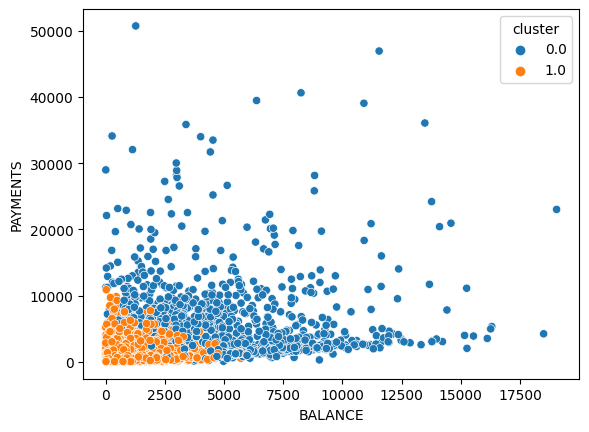

In [77]:
sns.scatterplot(x='BALANCE', y='PAYMENTS', hue='cluster', data=fin_clast) 
plt.show()

* Z grafu můžeme pozorovat, že uživatelé z budou mít malou částku plateb a málo peněz. Naopak uživatele z nulté skupiny budou mít hodně peněz a větší částku plateb. Zároveň nultá skupina má větší rozptyl a hodně odlehlých bodů.
* Teď prozkoumáme jak často probíhá aktualizace zůstatku vzhledem k počtu peněz na účtu.

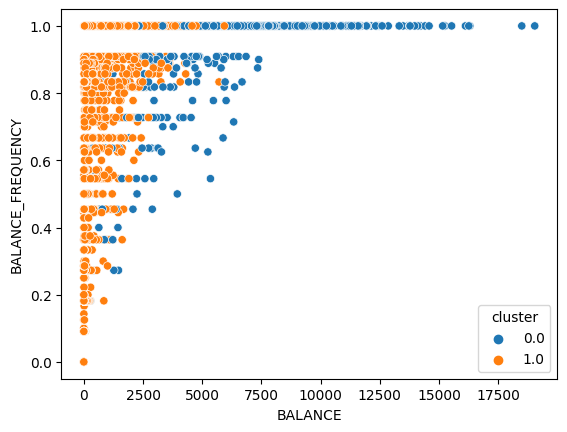

In [52]:
sns.scatterplot(x='BALANCE', y='BALANCE_FREQUENCY', hue='cluster', data=fin_clast) 
plt.show()

* Uživatele z nulté skupiny docela často aktualizují zůstatek na účtu, čím větší je počet peněz a čím častěji se aktualizuje účet tím víc je takových uživatelů z nulté skupiny. Naopak počet uživatelů z první skupiny roste pomaleji a vyskytuje nejvíc v intervalu frekvenci 0.6 až 0.8. V intervalu frekvenci 0 až 0.4 uživatele z nulté skupiny skoro nevyskytují.
* Prozkoumáme taky závislost mezi počtem peněz a kreditním limitem/minimální platbou pro obě skupiny uživatelů.

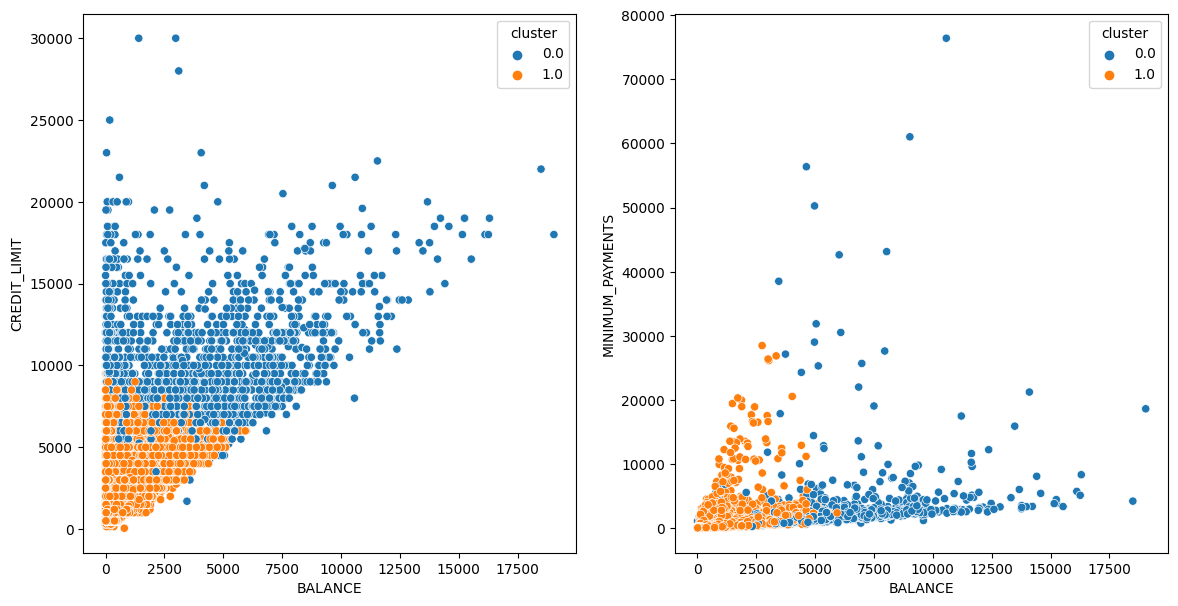

In [74]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
sns.scatterplot(x='BALANCE', y='CREDIT_LIMIT', hue='cluster', data=fin_clast, ax=ax1)
sns.scatterplot(x='BALANCE', y='MINIMUM_PAYMENTS', hue='cluster', data=fin_clast, ax=ax2) 
plt.show()

* Kreditní limit je větší u nulté skupiny uživatelů, první skupina má kreditní limit ve většině případu  menší. Na počtu peněz na účtu to docela nezáleží, několik odlehlých bodu z nulté skupiny mají docela málo peněz ale obrovský kreditní limit. 
* Minimální platby nezávisí na zůstatku na účtu, vždy jsou docela malé. Nultá a první skupina má ve většině případů malou částku minimální platby.

* Prozkoumáme taky závislost mezi zůstatkem na účtu a dobou platností účtu.

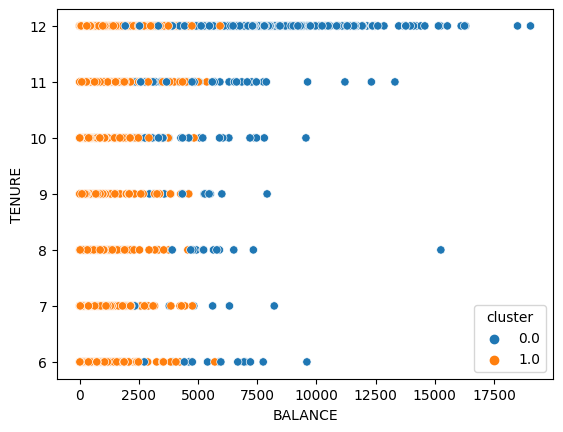

In [75]:
sns.scatterplot(x='BALANCE', y='TENURE', hue='cluster', data=fin_clast) 
plt.show()

* První skupina uživatelů je rozmístěna na intervalu od 0 do 5000 hodnoty zůstatku na účtu, a doba platnosti vzhledem k počtu uživatelů se nemění. Nultá skupina ve většině případu má mnohem víc peněz na účtu a doba platnosti bude většinou 11-12(let, měsíců? Informace o jednotkách není k dispozici).

### Shrnutí

* **Nultá** skupina uživatelů jsou bohaté lidé které mají hodně peněz na účtu, často aktualizují zůstatek na účtu(aktivní uživatele), mají velký kreditní limit a používají tento účet docela dlouho a nejspíš budou ho dal používat. Takových uživatelů je 21%.
* **První** skupina uživatelů má na účtu méně peněz a malou částku plateb. Aktualizuje zůstatek ve většině případu docela často ale méně než nultá skupina. Minimální částku platby má stejnou jako nultá skupina. Kreditní limit je taky skoro stejný. Doba platnosti účtu je od 6 do 12(nějakých jednotek), z toho plyne, že účet budou požívat jak krátkou dobu tak i docela dlouho. Takových uživatelů je 79%.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2421643f-ce1f-466c-9529-fdbed6870db6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>